<a href="https://colab.research.google.com/github/SERVIR/flood_mapping_intercomparison/blob/main/Section_C_Slope_And_Elevation_Statistical_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

In this script, we will conduct a statistical analysis of slope and elevation across all SERVIR countries. Our end goal is to obtain quartile values for both slope elevation. That is, what are the three elevation/slope values that will separate the number of pixels into four equal groups?

In Part 1, we will get extract geometries for our SERVIR regions. We will then split the geometry covering SERVIR regions at large into smaller geometries, as attempting to export this data for a large region results in computational errors from GEE. For exceptionally large countries such as Brazil & Mali, we will have to split these countries into smaller areas.

In Part 2, we will obtain the Shuttle Radar Topography Mission (SRTM) elevation data from Google Earth Engine and use the `ee.Algorithms.Terrain()` method to calculate the slope based on that elevation data. Then, for each of our subregions we created in Part 1, we will export the slope and elevation information in tabular format.

In Part 3, we will combine the data from our subregions into three arrays, one representing the pixel values (either for slope or elevation), one representing the number of pixels with that corresponding elevation value, and the final represeting the number of pixels with that corresponding slope value.

In Part 4, we will plot the elevation and slope values to find good quartile values (i.e. 0.25 quartile, 0.5 quartile (median), and 0.75 quartile) for both slope and elevation.

**NOTICE: This script will take about 1-2 hours to run and may return computational timeouts depending on GEE compute availability.**

# Part 1: Get Region(s) of Interest

### Part 1 Step 1: Import Necessary Packages

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import geemap
import ee

In order to continue running this script, you need to be associated with a Google Cloud Project. Now, we have to authenticate and initialize earth engine. After you run the code below, click through the pop-up window to login to the Google Account associated with your Google Earth Engine account. Click "Continue" until you have returned to this notebook and a green checkmark appears to the left of the code cell below.

In [ ]:
ee.Authenticate()
ee.Initialize(project = 'servir-sco-assets')

## Part 1 Step 2: Get SERVIR countries

Get the Global Administrative Unit Layers (GAUL) dataset produced by the United Nations Food And Agriculture Organization. Then extract each SERVIR country using the `.filter` method

In [ ]:
# gaul = Global Administrative Unit Layers
gaul = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level0")

##Amazonia
br = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))
co = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Colombia'))
ec = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Ecuador'))
pe = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Peru'))
gu = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Guyana'))
su = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Suriname'))
ba = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Bahamas'))
bb = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Barbados'))
dr = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Dominican Republic'))
tt = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Trinidad and Tobago'))

#Central America
bz = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Belize'))
cr = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Costa Rica'))
es= gaul.filter(ee.Filter.eq('ADM0_NAME', 'El Salvador'))
gt = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Guatemala'))
ho = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Honduras'))
pa = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Panama'))

#HKH
bg = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Bangladesh'))
ne = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Nepal'))
pk = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Pakistan'))
bt = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Bhutan'))

#Southeast Asia
ca = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Cambodia'))
id = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Indonesia'))
vn = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Viet Nam'))
lo = gaul.filter(ee.Filter.eq('ADM0_NAME', "Lao People's Democratic Republic"))
my = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Myanmar'))
ph = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Philippines'))
th = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Thailand'))

#West Africa
se = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Senegal'))
mi = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Mali'))
bf = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Burkina Faso'))
gh = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Ghana'))
ni = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Niger'))
na = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Nigeria'))
mo = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Morocco'))
al = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Algeria'))
ma = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Mauritania'))
gb = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Guinea-Bissau'))
ga = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Guinea'))
sl = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Sierra Leone'))
la = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Liberia'))
cd = gaul.filter(ee.Filter.eq('ADM0_NAME', "Côte d'Ivoire"))
to = gaul.filter(ee.Filter.eq('ADM0_NAME', "Togo"))
bn = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Benin'))
ch = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Chad'))


In [ ]:
mag = ma.geometry().getInfo()
bng = bn.geometry().getInfo()
#print(mag)
print(bn.getInfo())

{'type': 'FeatureCollection', 'columns': {'ADM0_CODE': 'Integer', 'ADM0_NAME': 'String', 'DISP_AREA': 'String', 'EXP0_YEAR': 'Integer', 'STATUS': 'String', 'STR0_YEAR': 'Integer', 'Shape_Area': 'Float', 'Shape_Leng': 'Float', 'system:index': 'String'}, 'version': 1701682711714479, 'id': 'FAO/GAUL_SIMPLIFIED_500m/2015/level0', 'properties': {'system:asset_size': 56724926}, 'features': [{'type': 'Feature', 'geometry': {'type': 'GeometryCollection', 'geometries': [{'type': 'LineString', 'coordinates': [[1.9268584205713577, 6.294853325013422], [1.924612664836426, 6.294853325013422], [1.9223669091014943, 6.294853325013422], [1.9201211533665625, 6.294853325013422], [1.9178753976316305, 6.294853325013422], [1.915629641896699, 6.294853325013422]]}, {'type': 'LineString', 'coordinates': [[1.9111381304268358, 6.308327859423011], [1.9088923746919042, 6.308327859423012], [1.9088923746919046, 6.30608210368808], [1.9111381304268358, 6.306082103688079]]}, {'type': 'LineString', 'coordinates': [[1.938

In [ ]:
# Create different SERVIR West Africa Subregions
swa1 = se.merge(bf) # SERVIR West Affrica Region 1
swa2 = gh.merge(ni) # "                        " 2
swa3 = na
swa4 = al
swa5 = ga.merge(gb)
swa6 = sl.merge(la)
swa7 = cd.merge(to)
swa8 = mi         # Mali not working
swa9 = ch
swa10 = ma
swa11 = mo
swa12 = bn

swa = swa1.merge(swa2).merge(swa3).merge(swa4).merge(swa5).merge(swa6).merge(swa7).merge(swa8).merge(swa9).merge(swa10).merge(swa11).merge(swa12)

# Create Different Regions for SERVIR Hindu Kush Himalaya
shkh1 = bg;
shkh2 = ne;
shkh3 = pk
shkh4 = bt;

shkh = shkh1.merge(shkh2).merge(shkh3).merge(shkh4)

# Create Different Regions for SERVIR Amazonia

samz1 = co
samz2 = ec;
samz3 = pe;
samz4 = gu.merge(su);
samz5 = ba                # Bahamas not working


# Brazil is too large to run this code alone, so we will need to split it in half
gaul2 = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level1")

brzl1 = gaul2.filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))
acre = brzl1.filter(ee.Filter.eq('ADM1_NAME', 'Acre'))
alagoas = brzl1.filter(ee.Filter.eq('ADM1_NAME', 'Alagoas'))
amapa = brzl1.filter(ee.Filter.eq('ADM1_NAME', 'Amapa'))
amazonas = brzl1.filter(ee.Filter.eq('ADM1_NAME', 'Amazonas'))
bahia = brzl1.filter(ee.Filter.eq('ADM1_NAME', 'Bahia'))
ceara = brzl1.filter(ee.Filter.eq('ADM1_NAME', 'Ceara'))
df = brzl1.filter(ee.Filter.eq('ADM1_NAME', 'Distrito Federal'))
espirito_santo = brzl1.filter(ee.Filter.eq('ADM1_NAME', 'Espirito Santo'))
goias = brzl1.filter(ee.Filter.eq('ADM1_NAME', 'Goias'))
maranhao = brzl1.filter(ee.Filter.eq('ADM1_NAME', 'Maranhao'))
matogrosso = brzl1.filter(ee.Filter.eq('ADM1_NAME', 'Mato Grosso'))
mgds = brzl1.filter(ee.Filter.eq('ADM1_NAME', 'Mato Grosso Do Sul')) #check
minasgerais = brzl1.filter(ee.Filter.eq('ADM1_NAME', 'Minas Gerais')) #check
para = brzl1.filter(ee.Filter.eq('ADM1_NAME', 'Para')) #check
paraiba = brzl1.filter(ee.Filter.eq('ADM1_NAME', 'Paraiba')) #check
parana = brzl1.filter(ee.Filter.eq('ADM1_NAME', 'Parana')) #check
pernambuco = brzl1.filter(ee.Filter.eq('ADM1_NAME', 'Pernambuco')) #check
piaui = brzl1.filter(ee.Filter.eq('ADM1_NAME', 'Piaui')) #check
rdj = brzl1.filter(ee.Filter.eq('ADM1_NAME', 'Rio De Janeiro')) #check
rgdn = brzl1.filter(ee.Filter.eq('ADM1_NAME', 'Rio Grande Do Norte')) #check
rgds = brzl1.filter(ee.Filter.eq('ADM1_NAME', 'Rio Grande Do Sul')) #check
rondonia = brzl1.filter(ee.Filter.eq('ADM1_NAME', 'Rondonia')) #check
roraima = brzl1.filter(ee.Filter.eq('ADM1_NAME', 'Roraima')) #check
santa_catarina = brzl1.filter(ee.Filter.eq('ADM1_NAME', 'Santa Catarina')) #check
sao_paulo = brzl1.filter(ee.Filter.eq('ADM1_NAME', 'Sao Paulo')) #check
sergipe = brzl1.filter(ee.Filter.eq('ADM1_NAME', 'Sergipe')) #check
tocantins = brzl1.filter(ee.Filter.eq('ADM1_NAME', 'Tocantins')) #check

samz6 = acre.merge(alagoas)

samz7 = paraiba.merge(parana)

samz8 = santa_catarina.merge(sao_paulo)

samz9 = ceara.merge(df).merge(espirito_santo).merge(goias)

samz10 = rdj

samz11 = maranhao

samz12 = amapa.merge(amazonas)

samz13 = rondonia.merge(roraima)

samz14 = minasgerais

samz15 = pernambuco.merge(piaui)

samz16 = dr

samz17 = bb

samz18 = para

samz19 = rgdn

samz20 = matogrosso.merge(bahia)

samz21 = rgds

samz22 = mgds

samz23 = sergipe.merge(tocantins)

samz = samz1.merge(samz2).merge(samz3).merge(samz4).merge(samz5).merge(samz6) \
       .merge(samz7).merge(samz8).merge(samz9).merge(samz10).merge(samz11)    \
       .merge(samz12).merge(samz13).merge(samz14).merge(samz15).merge(samz16) \
       .merge(samz17).merge(samz18).merge(samz19).merge(samz20).merge(samz21) \
       .merge(samz22).merge(samz23)

# Create Different Regions for SERVIR Southeast Asia
sea1 = ca
sea2 = vn.merge(lo);
sea3 = ph;
sea4 = th;
sea5 = my;

#Indonesia needs to be split into multiple regions
id2 = gaul2.filter(ee.Filter.eq('ADM0_NAME', 'Indonesia'));

maluku = id2.filter(ee.Filter.eq('ADM1_NAME', 'Maluku'));
maluku_utara = id2.filter(ee.Filter.eq('ADM1_NAME', 'Maluku Utara'))
bangka_belitung = id2.filter(ee.Filter.eq('ADM1_NAME', 'Bangka Belitung'))
banten = id2.filter(ee.Filter.eq('ADM1_NAME', 'Banten'))
gorontalo = id2.filter(ee.Filter.eq('ADM1_NAME', 'Gorontalo'))
jawa_barat = id2.filter(ee.Filter.eq('ADM1_NAME', 'Jawa Barat'))
sulawesi_utara = id2.filter(ee.Filter.eq('ADM1_NAME', 'Sulawesi Utara'))
sumatera_selatan = id2.filter(ee.Filter.eq('ADM1_NAME', 'Sumatera Selatan'))
kepulauan_riau = id2.filter(ee.Filter.eq('ADM1_NAME', 'Kepulauan-riau'))
riau = id2.filter(ee.Filter.eq('ADM1_NAME', 'Riau'))
sulawesi_barat = id2.filter(ee.Filter.eq('ADM1_NAME', 'Sulawesi Barat'))
sulawesi_selatan = id2.filter(ee.Filter.eq('ADM1_NAME', 'Sulawesi Selatan'))
nad = id2.filter(ee.Filter.eq('ADM1_NAME', 'Nangroe Aceh Darussalam'))
bali = id2.filter(ee.Filter.eq('ADM1_NAME', 'Bali'))
bengkulu = id2.filter(ee.Filter.eq('ADM1_NAME', 'Bengkulu'))
day = id2.filter(ee.Filter.eq('ADM1_NAME', 'Daerah Istimewa Yogyakarta'))
dki_jakarta = id2.filter(ee.Filter.eq('ADM1_NAME', 'Dki Jakarta'))
jambi = id2.filter(ee.Filter.eq('ADM1_NAME', 'Jambi'))
jawa_tengah = id2.filter(ee.Filter.eq('ADM1_NAME', 'Jawa Tengah'))
jawa_timur = id2.filter(ee.Filter.eq('ADM1_NAME', 'Jawa Timur'))
kali_barat = id2.filter(ee.Filter.eq('ADM1_NAME', 'Kalimantan Barat'));
kali_sela = id2.filter(ee.Filter.eq('ADM1_NAME', 'Kalimantan Selatan'));
kali_teng = id2.filter(ee.Filter.eq('ADM1_NAME', 'Kalimantan Tengah'));
kali_timur = id2.filter(ee.Filter.eq('ADM1_NAME', 'Kalimantan Timur'))
lampung = id2.filter(ee.Filter.eq('ADM1_NAME', 'Lampung'))
nusa_barat = id2.filter(ee.Filter.eq('ADM1_NAME', 'Nusatenggara Barat'))
nusa_timur = id2.filter(ee.Filter.eq('ADM1_NAME', 'Nusatenggara Timur'))
sula_teng = id2.filter(ee.Filter.eq('ADM1_NAME', 'Sulawesi Tengah'))
sula_ara = id2.filter(ee.Filter.eq('ADM1_NAME', 'Sulawesi Tenggara'))
suma_barat = id2.filter(ee.Filter.eq('ADM1_NAME', 'Sumatera Barat'))
suma_utara = id2.filter(ee.Filter.eq('ADM1_NAME', 'Sumatera Utara'))
papua_barat = id2.filter(ee.Filter.eq('ADM1_NAME', 'Papua Barat'))
papua = id2.filter(ee.Filter.eq('ADM1_NAME', 'Papua'))

sea6 = maluku.merge(maluku_utara)


sea7 = day.merge(dki_jakarta).merge(jambi).merge(jawa_tengah).merge(jawa_timur)                  \
            .merge(kali_barat)


sea8 = riau.merge(sulawesi_barat).merge(sulawesi_selatan).merge(nad).merge(bali)    \


sea9 = jawa_barat.merge(sulawesi_utara).merge(sumatera_selatan).merge(kepulauan_riau)

sea10 = bengkulu.merge(nusa_timur).merge(sula_teng).merge(sula_ara)

sea11 = suma_barat

sea12 = papua_barat

sea13 = bangka_belitung.merge(banten).merge(gorontalo)

sea14 = kali_sela.merge(kali_teng).merge(kali_timur).merge(lampung).merge(nusa_barat)

sea15 = suma_utara

sea16 = papua


sea = sea1.merge(sea2).merge(sea3).merge(sea4).merge(sea5).merge(sea6) \
      .merge(sea7).merge(sea8).merge(sea9).merge(sea10) \
      .merge(sea11).merge(sea12).merge(sea13).merge(sea14)

# SERVIR Central America
sca1 = es.merge(gt).merge(ho)
sca2 = pa;
sca3 = bz.merge(cr)

sca = sca1.merge(sca2).merge(sca3)

servir = swa.merge(sca).merge(sea).merge(shkh).merge(samz)

#sca_test = sca1.merge(sca2)

Visualize SERVIR countries

In [ ]:
Map = geemap.Map(center = (0, 0), zoom = 2)
Map.addLayer(servir, {}, 'SERVIR Countries')
Map.addLayerControl()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

# Part 2: Get Slope and Elevation Data

Currently we are only getting elevation data.

We will use elevation data from NASA's Shuttle Radar Topography Mission (SRTM) [Farr and Kobrick 2000]

In [ ]:
#srtm = ee.Image("USGS/SRTMGL1_003")

In [ ]:
copernicus = ee.ImageCollection("COPERNICUS/DEM/GLO30")

In [ ]:
# Make a function that

def histfunc(aoi):
  #srtm_clip = srtm.clip(aoi)
  #srtm_mod = ee.Algorithms.Terrain(srtm_clip).select(['elevation', 'slope'])
  cop_clip = copernicus.filterBounds(aoi).mosaic().clip(aoi).select(['DEM']).rename(['elevation'])
  cop_mod = ee.Algorithms.Terrain(cop_clip)#.select(['DEM', 'slope'])

  histdic = cop_mod.reduceRegion(**{
      'reducer': ee.Reducer.histogram(None, 1),
      'geometry': aoi.geometry(),
      'scale': 30,
      'maxPixels': 1e19
  })

  dic = histdic.getInfo()

  # Get Elevation Data
  elvdic = dic.get('elevation')
  #elvdic = dic.get('DEM')

  minev = elvdic.get('bucketMin')
  stepev = elvdic.get('bucketWidth')
  elv_pixcounts = elvdic.get('histogram')

  # Get Slope Data
  slodic = dic.get('slope')

  minslo = slodic.get('bucketMin')
  stepslo = slodic.get('bucketWidth')
  slo_pixcounts = slodic.get('histogram')

  elvals = []   # Elevation Values
  elvpc = []    # Elevation Pixel Counts

  slovals = []   # Slope Values
  slopc = []     # Slope Pixel Counts

  for i in range(len(elv_pixcounts)):
    elv_count = stepev * i
    ev = minev
    ev += elv_count
    elvals.append(ev)
    elvpc.append(elv_pixcounts[i])

  for j in range(len(slo_pixcounts)):
    slo_count = stepslo * j
    slo = minslo
    slo += slo_count
    slovals.append(slo)
    slopc.append(slo_pixcounts[j])

  return elvals, elvpc, slovals, slopc
  #return dic.keys()

# SERVIR West Africa

SWA1 - 6 Ran in about 10 minutes

In [ ]:
# SERVIR West Afirca
#swa1ev = histfunc(swa1)

swa1ev, swa1ep, swa1sv, swa1sp = histfunc(swa1)        # swa1ev = SERVIR West Africa Region 1 Elevation Values
                                                       # swa1ep = SERVIR West Africa Region 1 Elevation Pixel Counts
                                                       # swa1sv = SERVIR West Africa Region 1 Slope Values
                                                       # swa1sp = SERVIR West Africa Region 1 Slope Pixel Counts

In [ ]:
swa2ev, swa2ep, swa2sv, swa2sp = histfunc(swa2)

In [ ]:
swa3ev, swa3ep, swa3sv, swa3sp = histfunc(swa3)

In [ ]:
swa4ev, swa4ep, swa4sv, swa4sp = histfunc(swa4)

In [ ]:
swa5ev, swa5ep, swa5sv, swa5sp = histfunc(swa5)

In [ ]:
swa6ev, swa6ep, swa6sv, swa6sp = histfunc(swa6)

In [ ]:
swa7ev, swa7ep, swa7sv, swa7sp = histfunc(swa7)

In [ ]:
swa8ev, swa8ep, swa8sv, swa8sp = histfunc(swa8)

In [ ]:
swa9ev, swa9ep, swa9sv, swa9sp = histfunc(swa9)

In [ ]:
swa10ev, swa10ep, swa10sv, swa10sp = histfunc(swa10)

In [ ]:
swa11ev, swa11ep, swa11sv, swa11sp = histfunc(swa11)

In [ ]:
swa12ev, swa12ep, swa12sv, swa12sp = histfunc(swa12)

# SERVIR HKH

In [ ]:
shkh1ev, shkh1ep, shkh1sv, shkh1sp = histfunc(shkh1)
shkh2ev, shkh2ep, shkh2sv, shkh2sp = histfunc(shkh2)
shkh3ev, shkh3ep, shkh3sv, shkh3sp = histfunc(shkh3)
shkh4ev, shkh4ep, shkh4sv, shkh4sp = histfunc(shkh4)

# SERVIR Southeast Asia

In [ ]:
sea1ev, sea1ep, sea1sv, sea1sp = histfunc(sea1)

In [ ]:
sea2ev, sea2ep, sea2sv, sea2sp = histfunc(sea2)

In [ ]:
sea3ev, sea3ep, sea3sv, sea3sp = histfunc(sea3)

In [ ]:
sea4ev, sea4ep, sea4sv, sea4sp = histfunc(sea4)

In [ ]:
sea5ev, sea5ep, sea5sv, sea5sp = histfunc(sea5)

In [ ]:
sea6ev, sea6ep, sea6sv, sea6sp = histfunc(sea6)

In [ ]:
sea7ev, sea7ep, sea7sv, sea7sp = histfunc(sea7)

In [ ]:
sea8ev, sea8ep, sea8sv, sea8sp = histfunc(sea8)

In [ ]:
sea9ev, sea9ep, sea9sv, sea9sp = histfunc(sea9)

In [ ]:
sea10ev, sea10ep, sea10sv, sea10sp = histfunc(sea10)

In [ ]:
sea11ev, sea11ep, sea11sv, sea11sp = histfunc(sea11)

In [ ]:
sea12ev, sea12ep, sea12sv, sea12sp = histfunc(sea12)

In [ ]:
sea13ev, sea13ep, sea13sv, sea13sp = histfunc(sea13)

In [ ]:
sea14ev, sea14ep, sea14sv, sea14sp = histfunc(sea14)

In [ ]:
sea15ev, sea15ep, sea15sv, sea15sp = histfunc(sea15)

In [ ]:
sea16ev, sea16ep, sea16sv, sea16sp = histfunc(sea16)

# SERVIR Amazonia

In [ ]:
samz1ev, samz1ep, samz1sv, samz1sp = histfunc(samz1)
samz2ev, samz2ep, samz2sv, samz2sp = histfunc(samz2)
samz3ev, samz3ep, samz3sv, samz3sp = histfunc(samz3)


In [ ]:
samz4ev, samz4ep, samz4sv, samz4sp = histfunc(samz4)

In [ ]:
samz5ev, samz5ep, samz5sv, samz5sp = histfunc(samz5)

In [ ]:
samz6ev, samz6ep, samz6sv, samz6sp = histfunc(samz6)

In [ ]:
samz7ev, samz7ep, samz7sv, samz7sp = histfunc(samz7)

In [ ]:
samz8ev, samz8ep, samz8sv, samz8sp = histfunc(samz8)

In [ ]:
samz9ev, samz9ep, samz9sv, samz9sp = histfunc(samz9)

In [ ]:
samz10ev, samz10ep, samz10sv, samz10sp = histfunc(samz10)

In [ ]:
samz11ev, samz11ep, samz11sv, samz11sp = histfunc(samz11)

In [ ]:
samz12ev, samz12ep, samz12sv, samz12sp = histfunc(samz12)

In [ ]:
samz13ev, samz13ep, samz13sv, samz13sp = histfunc(samz13)

In [ ]:
samz14ev, samz14ep, samz14sv, samz14sp = histfunc(samz14)

In [ ]:
samz15ev, samz15ep, samz15sv, samz15sp = histfunc(samz15)

In [ ]:
samz16ev, samz16ep, samz16sv, samz16sp = histfunc(samz16)

AttributeError: 'NoneType' object has no attribute 'get'

In [ ]:
samz17ev, samz17ep, samz17sv, samz17sp = histfunc(samz17)

AttributeError: 'NoneType' object has no attribute 'get'

In [ ]:
samz18ev, samz18ep, samz18sv, samz18sp = histfunc(samz18)

In [ ]:
samz19ev, samz19ep, samz19sv, samz19sp = histfunc(samz19)

In [ ]:
samz20ev, samz20ep, samz20sv, samz20sp = histfunc(samz20)

In [ ]:
samz21ev, samz21ep, samz21sv, samz21sp = histfunc(samz21)

In [ ]:
samz22ev, samz22ep, samz22sv, samz22sp = histfunc(samz22)

In [ ]:
samz23ev, samz23ep, samz23sv, samz23sp = histfunc(samz23)

# SERVIR Central America

In [ ]:
sca1ev, sca1ep, sca1sv, sca1sp = histfunc(sca1)
sca2ev, sca2ep, sca2sv, sca2sp = histfunc(sca2)

In [ ]:
sca3ev, sca3ep, sca3sv, sca3sp = histfunc(sca3)

Now we have to aggregate the elevations and pixel counts into two arrays

In [ ]:
#from os import sched_getaffinity
elevation_arrays = [sca1ev, sca2ev, sca3ev,                            # SERVIR Central America
                    sea1ev, sea2ev, sea3ev, sea4ev, sea5ev, sea6ev,    # SERVIR Southeast Asia
                    sea7ev, sea8ev, sea9ev, sea10ev, sea11ev, sea12ev,
                    swa1ev, swa2ev, swa3ev, swa4ev, swa5ev, swa6ev,    # SERVIR West Africa
                    swa7ev, swa8ev, swa9ev, swa10ev, swa11ev, swa12ev,
                    shkh1ev, shkh2ev, shkh3ev, shkh4ev,                # SERVIR Hindu Kush Himalaya
                    samz1ev, samz2ev, samz3ev, samz4ev,                # SERVIR Amazonia
                    samz5ev, samz6ev, samz7ev, samz8ev,
                    samz9ev, samz10ev, samz11ev, samz12ev,
                    samz13ev, samz14ev, samz15ev,
                    samz18ev, samz19ev, samz20ev, samz21ev,
                    samz22ev, samz23ev]# samz16ev, samz17ev]           # SAMZ16 and SAMZ17 no longer working

# Pixel Count Arrays
elv_pc_arrays = [sca1ep, sca2ep, sca3ep,                            # SERVIR Central America
             sea1ep, sea2ep, sea3ep, sea4ep, sea5ep, sea6ep,        # SERVIR Southeast Asia
             sea7ep, sea8ep, sea9ep, sea10ep, sea11ep, sea12ep,
             swa1ep, swa2ep, swa3ep, swa4ep, swa5ep, swa6ep,        # SERVIR West Africa
             swa7ep, swa8ep, swa9ep, swa10ep, swa11ep, swa12ep,
             shkh1ep, shkh2ep, shkh3ep, shkh4ep,                    # SERVIR Hinduu Kush Himalaya
             samz1ep, samz2ep, samz3ep, samz4ep,                    # SERVIR Amazonia
             samz5ep, samz6ep, samz7ep, samz8ep,
             samz9ep, samz10ep, samz11ep, samz12ep, samz13ep,
             samz14ep, samz15ep, samz18ep,
             samz19ep, samz20ep, samz21ep, samz22ep, samz23ep]        # samz16ep, samz17ep,

# Slope value arrays
slope_arrays = [sca1sv, sca2sv, sca3sv,                               # SERVIR Central America
                sea1sv, sea2sv, sea3sv, sea4sv, sea5sv, sea6sv,       # SERVIR Southeast Asia
                sea7sv, sea8sv, sea9sv, sea10sv, sea11sv, sea12sv,
                swa1sv, swa2sv, swa3sv, swa4sv, swa5sv, swa6sv,       # SERVIR West Africa
                swa7sv, swa8sv, swa9sv, swa10sv, swa11sv, swa12sv,
                shkh1sv, shkh2sv, shkh3sv, shkh4sv,                   # SERVIR Hinduu Kush Himalaya
                samz1sv, samz2sv, samz3sv, samz4sv, samz5sv,
                samz6sv, samz7sv, samz8sv, samz9sv, samz10sv,         # SERVIR Amazonia
                samz11sv, samz12sv, samz13sv, samz14sv, samz15sv,
                samz18sv, samz19sv,
                samz20sv, samz21sv, samz22sv, samz23sv]               # samz16sv, samz17sv,          # samz16ep, samz17ep,

# slope pixel count arrays
slo_pc_arrays = [sca1sp, sca2sp, sca3sp,                              # SERVIR Central America
                sea1sp, sea2sp, sea3sp, sea4sp, sea5sp, sea6sp,      # SERVIR Southeast Asia
                sea7sp, sea8sp, sea9sp, sea10sp, sea11sp, sea12sp,
                swa1sp, swa2sp, swa3sp, swa4sp, swa5sp, swa6sp,      # SERVIR West Africa
                swa7sp, swa8sp, swa9sp, swa10sp, swa11sp, swa12sp,
                shkh1sp, shkh2sp, shkh3sp, shkh4sp,                  # SERVIR Hinduu Kush Himalaya
                samz1sp, samz2sp, samz3sp, samz4sp, samz5sp,         # SERVIR Amazonia
                samz6sp, samz7sp, samz8sp, samz9sp, samz10sp,
                samz11sp, samz12sp, samz13sp, samz14sp, samz15sp,
                samz18sp, samz19sp,
                samz20sp, samz21sp, samz22sp, samz23sp]                # samz16sp, samz17sp,

sanity_check = len(elevation_arrays) == len(elv_pc_arrays) == len(slope_arrays) == len(slo_pc_arrays)
print("Are the arrays above equal in length? Should be true:", sanity_check)

Are the arrays above equal in length? Should be true: True


Now we will use a nested for-loop to aggregate all elevation values into an array called `el_master`, all elevation pixel count arrays into an array called `elv_pc_master`, all slope values into an array called `sl_master`, and all slope pixel count arrays into an array called `sl_pc_master`

In [ ]:
el_master = []
elv_pc_master = [] # Elevation Pixel Count
sl_master = []
sl_pc_master = []


for i in range(len(elevation_arrays)):     # For all elevation arrays
  eva = elevation_arrays[i]              # Elevation Value Array
  epca = elv_pc_arrays[i]                 # Elevation Pixel Count Array
  sva = slope_arrays[i]                  # Slope Value Array
  spca = slo_pc_arrays[i]                 # Slope Pixel Count Array
  for j in range(len(eva)):
    ev_val = eva[j]                       # Elevation value of interest
    epc_val = epca[j]                     # Elevation Pixel Count value of


    if ev_val not in el_master:           # If the elevation value is not in master elevation array...
      if ev_val > -420 and ev_val < 8848 and epc_val != 0:         # Mask out bad data (elevation lower than lowest elevation and higher than highest elevation) and disregard elevations that have a pixel value of 0.
        el_master.append(ev_val)            # Append the elevation value of interest into the master elevation array
        elv_pc_master.append(epc_val)     # Append the pixel count value of interest into the master pixel count array
    else:                                  # If elevation value is not in master elevation array...
      indexo = el_master.index(ev_val)    # Get the index value of the elevation value in the master array
      elv_pc_master[indexo] += epc_val    # Add the pixel value of interest to the existing pixel count in the master pixel count array


  for k in range(len(sva)):
    sv_val = sva[k]                       # Slope Value of interest
    spc_val = spca[k]                     # Slope Pixel Count Value of interest
    if sv_val not in sl_master:
      sl_master.append(sv_val)
      sl_pc_master.append(spc_val)
    else:
      indexi = sl_master.index(sv_val)
      sl_pc_master[indexi] += spc_val

# Part 4: Visualize Data and Find Quartile Values

### Part 4 Section 1: Elevation

First, we have to sort the elevation data

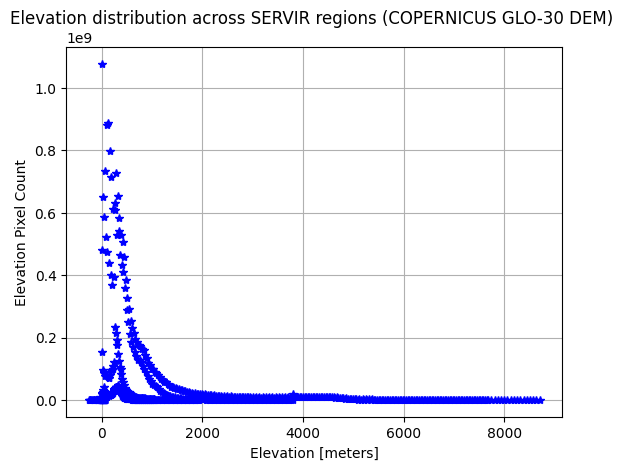

In [ ]:
plt.plot(el_master, elv_pc_master, '*b')
plt.ylabel('Elevation Pixel Count')
plt.xlabel('Elevation [meters]')
plt.title('Elevation distribution across SERVIR regions (COPERNICUS GLO-30 DEM) ')
plt.grid()

In [ ]:
#Find total pixels
sum = 0
for p in range(len(el_master)):
  elval = el_master[p]
  elpixc = elv_pc_master[p]
  sum += elpixc
print('Total Number of Valid Pixels for Elevation Data: {0:2.2e}'.format(sum))

Total Number of Valid Pixels for Elevation Data: 3.07e+10


In [ ]:
num_pix = sum / 4
num_pix

print("We want to split the data into four equal groups, each containing approximately {0:2.2e} pixels".format(num_pix))

We want to split the data into four equal groups, each containing approximately 7.69e+09 pixels


Let's sort the elevation data and pixel counts

In [ ]:
# Put the data into a 2D Array
elv2d = [[]]
for u in range(len(el_master)):
  elval = el_master[u]
  elpixc = elv_pc_master[u]

  mylist = []
  mylist.append(elval)
  mylist.append(elpixc)

  elv2d.append(mylist)
# Sort the data by the first column
elv2d_sorted = sorted(elv2d)[1:]

# Put the data back into 2 1-D Arrays
elval_sorted = []
elpc_sorted = []

for v in range(len(elv2d_sorted)):
  elvaoi = elv2d_sorted[v]              # Elevation Array of interest
  elval_sorted.append(elvaoi[0])
  elpc_sorted.append(elvaoi[1])


Use a for loop to find the ideal values to split each group into four groups

In [ ]:
q1sum = 0
q2sum = 0
q3sum = 0
q4sum = 0
q1_val = 0
q2_val = 0
q3_val = 0
q4_val = 0

# Quartile 1
for s in range(len(elval_sorted)):           # len(elval_sorted
  elval = elval_sorted[s]
  elpixc = elpc_sorted[s]
  q1diffold =np.abs(q1sum - num_pix)
  q1sum += elpixc
  q1diff = np.abs(q1sum - num_pix)
  if q1diffold < q1diff:
    q1_val = elval
    break


print("Number of pixels with an elevation greater than {0} and less than {1} meters:  {2:2.2e}".format(-420, q1_val, q1sum))

# Quartile 2
for w in range(len(elval_sorted)):
  elval = elval_sorted[w]
  elpixc = elpc_sorted[w]
  if elval > q1_val:
    q2diffold = np.abs(q2sum - num_pix)
    q2sum += elpixc
    q2diff = np.abs(q2sum - num_pix)
    if q2diffold < q2diff:
      q2_val = elval
      break

print("Number of pixels with an elevation greater than {0} and less than {1} meters:   {2:2.2e}".format(q1_val, q2_val, q2sum))

# Quartile 3
for x in range(len(elval_sorted)):
  elval = elval_sorted[x]
  elpixc = elpc_sorted[x]
  if elval > q2_val:
    q3diffold = np.abs(q3sum - num_pix)
    q3sum += elpixc
    q3diff = np.abs(q3sum - num_pix)
    if q3diffold < q3diff:
      q3_val = elval
      break

print("Number of pixels with an elevation greater than {0} and less than {1} meters:   {2:2.2e}".format(q2_val, q3_val, q3sum))


# Quartile 4
for y in range(len(elval_sorted)):
  elval = elval_sorted[y]
  elpixc = elpc_sorted[y]
  if elval > q3_val:
    q4sum += elpixc


print("Number of pixels with an elevation greater than {0} meters:                     {1:2.2e}".format(q3_val, q4sum))

Number of pixels with an elevation greater than -420 and less than 144 meters:  7.95e+09
Number of pixels with an elevation greater than 144 and less than 312 meters:   7.85e+09
Number of pixels with an elevation greater than 312 and less than 544 meters:   7.87e+09
Number of pixels with an elevation greater than 544 meters:                     7.07e+09


This splits the data up into four roughly equal groups. There is no way to evenly split the data. Below shows an attempt to manually find even quartiles, but there is still a difference

In [ ]:
q1vm = 140
q2vm = 300
q3vm = 496
sum1test = 0
sum2test = 0
sum3test = 0
sum4test = 0

for alpha in range(len(elval_sorted)):
  elval = elval_sorted[alpha]
  elpc = elpc_sorted[alpha]
  if elval <= q1vm:
    sum1test += elpc
  if elval > q1vm and elval <= q2vm:
    sum2test += elpc
  if elval > q2vm and elval <= q3vm:
    sum3test += elpc
  if elval > q3vm:
    sum4test += elpc

print('Number of Pixels with an elevation greater than {0} but less than {1} meters: {2:2.2e}'.format("-420", q1vm, sum1test))
print('Number of Pixels with an elevation greater than {0} but less than {1} meters:  {2:2.2e}'.format(q1vm, q2vm, sum2test))
print('Number of Pixels with an elevation greater than {0} but less than {1} meters:  {2:2.2e}'.format(q2vm, q3vm, sum3test))
print('Number of Pixels with an elevation greater than {0} meters:                    {1:2.2e}'.format(q3vm, sum4test))

Number of Pixels with an elevation greater than -420 but less than 140 meters: 7.52e+09
Number of Pixels with an elevation greater than 140 but less than 300 meters:  7.54e+09
Number of Pixels with an elevation greater than 300 but less than 496 meters:  7.65e+09
Number of Pixels with an elevation greater than 496 meters:                    8.04e+09


## Part 4 Section 2: Slope

Text(0, 0.5, 'Pixel Count')

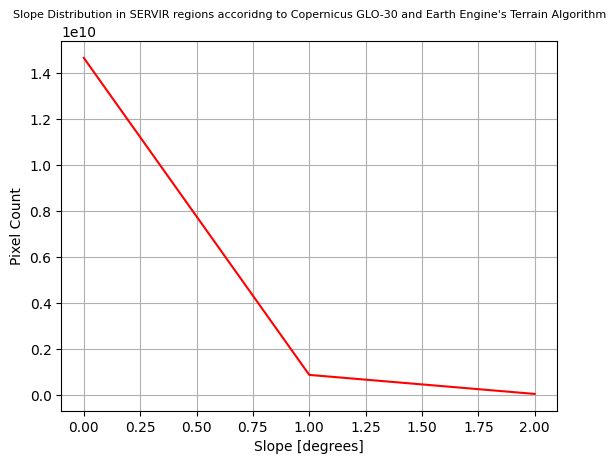

In [ ]:
plt.plot(sl_master, sl_pc_master, '-r')
plt.grid()
plt.title("Slope Distribution in SERVIR regions accoridng to Copernicus GLO-30 and Earth Engine's Terrain Algorithm", fontsize = 8)
plt.xlabel('Slope [degrees]')
plt.ylabel('Pixel Count')

In [ ]:
# Put the data into a 2D Array
sl2d = [[]]
for beta in range(len(sl_master)):
  slval = sl_master[beta]
  slpixc = sl_pc_master[beta]

  mylist = []
  mylist.append(slval)
  mylist.append(slpixc)

  sl2d.append(mylist)
# Sort the data by the first column
sl2d_sorted = sorted(sl2d)[1:]

# Put the data back into 2 1-D Arrays
slval_sorted = []
slpc_sorted = []

for gamma in range(len(sl2d_sorted)):
  slaoi = sl2d_sorted[gamma]              # Slope Array of interest
  slval_sorted.append(slaoi[0])
  slpc_sorted.append(slaoi[1])

In [ ]:
#Find total pixels
sum2 = 0
for q in range(len(sl_master)):
  slval = sl_master[q]
  slpixc = sl_pc_master[q]
  sum2 += slpixc

slopepix = sum2 / 4

print("Number of pixels each group should have: {0:e}".format(slopepix))

Number of pixels each group should have: 3.885999e+09


In [ ]:
sq1sum = 0
sq2sum = 0
sq3sum = 0
sq4sum = 0
sq1_val = 0
sq2_val = 0
sq3_val = 0
sq4_val = 0

# Quartile 1
for delta in range(len(slval_sorted)):
  slval = slval_sorted[delta]
  slpixc = slpc_sorted[delta]
  sq1diffold =np.abs(sq1sum - slopepix)
  sq1sum += slpixc
  sq1diff = np.abs(sq1sum - slopepix)
  if sq1diffold < sq1diff:
    sq1_val += slval
    break

print('Number of Pixels with an elevation less than {0} meters:                     {1:2.2e}'.format(sq1_val, sq1sum))

# Quartile 2
for epsilon in range(len(slval_sorted)):
  slval = slval_sorted[epsilon]
  slpixc = slpc_sorted[epsilon]
  if slval > sq1_val:
    sq2diffold = np.abs(sq2sum - slopepix)
    sq2sum += slpixc
    sq2diff = np.abs(sq2sum - slopepix)
    if sq2diffold < sq2diff:
      sq2_val = slval
      break

print('Number of Pixels with an elevation greater than {0} but less than {1} meters:  {2:2.2e}'.format(sq1_val, sq2_val, sq2sum))

# Quartile 3
for zeta in range(len(slval_sorted)):
  slval = slval_sorted[zeta]
  slpixc = slpc_sorted[zeta]
  if slval > sq2_val:
    sq3diffold = np.abs(sq3sum - slopepix)
    sq3sum += slpixc
    sq3diff = np.abs(sq3sum - slopepix)
    if sq3diffold < sq3diff:
      sq3_val = slval
      break

print('Number of Pixels with an elevation greater than {0} but less than {1} meters: {2:2.2e}'.format(sq2_val, sq3_val, sq3sum))


# Quartile 4
for eta in range(len(slval_sorted)):
  slval = slval_sorted[eta]
  slpixc = slpc_sorted[eta]
  if slval > sq3_val:
    sq4sum += slpixc


print('Number of Pixels with an elevation less than {0} meters:                    {1:2.2e}'.format(sq3_val, sq4sum))

Number of Pixels with an elevation less than 0 meters:                     1.46e+10
Number of Pixels with an elevation greater than 0 but less than 0 meters:  8.98e+08
Number of Pixels with an elevation greater than 0 but less than 0 meters: 8.98e+08
Number of Pixels with an elevation less than 0 meters:                    8.98e+08


Now that we know the approximate values, let's manually alter them to more evenly distribute the points.

In [ ]:
sq1vm = 2
sq2vm = 4
sq3vm = 9
ss1 = 0        # Slope Sum 1
ss2 = 0
ss3 = 0
ss4 = 0

for theta in range(len(slval_sorted)):
  slval = slval_sorted[theta]
  slpc = slpc_sorted[theta]
  if slval <= sq1vm:
    ss1 += slpc
  if slval > sq1vm and slval <= sq2vm:
    ss2 += slpc
  if slval > sq2vm and slval <= sq3vm:
    ss3 += slpc
  if slval > sq3vm:
    ss4 += slpc

print('Number of Pixels with a slope less than {0} degrees:                    {1:e}'.format(sq1vm, ss1))
print('Number of Pixels with a slope greater than {0} but less than {1} degrees: {2:e}'.format(sq1vm, sq2vm, ss2))
print('Number of Pixels with a slope greater than {0} but less than {1} degrees: {2:e}'.format(sq2vm, sq3vm, ss3))
print('Number of Pixels with a slope greater than {0} degrees:                 {1:e}'.format(sq3vm, ss4))

Number of Pixels with a slope less than 2 degrees:                    1.554399e+10
Number of Pixels with a slope greater than 2 but less than 4 degrees: 0.000000e+00
Number of Pixels with a slope greater than 4 but less than 9 degrees: 0.000000e+00
Number of Pixels with a slope greater than 9 degrees:                 0.000000e+00


# Part 5: References

Farr, Tom G., and Mike Kobrick. "Shuttle Radar Topography Mission produces a wealth of data." Eos, Transactions American Geophysical Union 81.48 (2000): 583-585.